In [9]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");

v3.0


In [161]:
# Load initial wave
function get_stretch_param(Lx)
    param = get_grid_param(21,11)
    @unpack Nx = param
    param["save_interval"] = 100.0
    param["name"] = "soliton_stretch"
    param["Lx"] = Float64(Lx)
    param["Δx"] = Float64(Lx/Nx)
    return param
end

function get_dense_param(Lx, ΔX; save_interval = 1.0)
    param = get_stretch_param(Lx)
    @pack! param = save_interval

    while param["Δx"] > ΔX
        param = double_param(param)
    end
    return param
end

function double_param(param)
    @unpack Nx, Lx, Δx = param
    NNx = Int64(2*Nx)
    Δx = Δx/2
    Nx = NNx
    @pack! param = Δx, Nx
    return param
end

param = get_dense_param(20, 0.0125)
T = 10000.0
@pack! param = T
loaded, f, t = quiet_load_last_pde(param)
i = argmax(sum(f;dims=3)[:,1])
@unpack Nx = param
f = circshift(f,((Nx÷2)-i,0));
param["Δx"]

0.0125

In [166]:
# Outer Equations
function circ_diff(f,param)
    @unpack Δx = param
    df= (f - circshift(f, (1,0)))/Δx
    return df
end
function circ_diff_1d(rho, param)
    @unpack Δx = param
    df= (rho - circshift(f, 1))/Δx
    return df
end

function full_eq_test(f, param)
    @unpack DT, v0, DR, Nx, Δx = param
    rho = sum(f; dims = 2)
    mag = f[:,2] - f[:,1]
    ds = self_diff.(rho)
    DD = (-ds .+1)./rho
    ss = DD .-1

    df= (circshift(f, (-1,0))-f)/Δx
    drho= (circshift(rho, -1)-rho)/Δx
    _, c, _ = f_dot(param, f)

    σ = zeros(Nx,3)
    σ[:,1] = -ones(Nx)
    σ[:,2] = ones(Nx)

    diff = DT*circ_diff(ds.*df + f.*DD.*drho,param )
    drft = -v0*circ_diff((f.*σ).*ds + f.*ss.*mag,param)
    flip = -DR*σ.*mag # this might error
    total = abs.(diff+drft+flip-c*df)
    return total[:,1], total[:,2], total[:,3]
end

function inner_test(f, param)
    @unpack DT, v0, DR, Nx, Δx = param
    rho = sum(f; dims = 2)
    mag = f[:,2] - f[:,1]
    ds = self_diff.(rho)
    DD = (-ds .+1)./rho
    ss = DD .-1

    df= (circshift(f, (-1,0))-f)/Δx
    drho= (circshift(rho, -1)-rho)/Δx
    _, c, _ = f_dot(param, f)

    σ = zeros(Nx,3)
    σ[:,1] = -ones(Nx)
    σ[:,2] = ones(Nx)

    diff = DT*circ_diff(ds.*df + f.*DD.*drho,param )
    drft = -v0*circ_diff((f.*σ).*ds + f.*ss.*mag,param)
    flip = -DR*σ.*mag # this might error
    total = abs.(diff+drft+flip)

    int_diff = DT*(ds.*df + f.*DD.*drho)
    int_drft = -v0*((f.*σ).*ds + f.*ss.*mag)

    return abs.(int_diff[:,3]+int_drft[:,3]), abs.(sum(int_diff+int_drft; dims =2)), total[:,1]
end

function outer_test(f, param)
    @unpack DT, v0, DR, Nx, Δx = param
    rho = sum(f; dims = 2)
    mag = f[:,2] - f[:,1]
    ds = self_diff.(rho)
    DD = (-ds .+1)./rho
    ss = DD .-1

    df= (circshift(f, (-1,0))-f)/Δx
    drho= (circshift(rho, -1)-rho)/Δx
    _, c, _ = f_dot(param, f)

    σ = zeros(Nx,3)
    σ[:,1] = -ones(Nx)
    σ[:,2] = ones(Nx)

    diff = DT*circ_diff(ds.*df + f.*DD.*drho,param )
    drft = -v0*circ_diff((f.*σ).*ds + f.*ss.*mag,param)
    flip = -DR*σ.*mag # this might error
    total = abs.(diff+drft+flip-c*df)

    int_diff = DT*(ds.*df + f.*DD.*drho)
    int_drft = -v0*((f.*σ).*ds + f.*ss.*mag)


    lead_drft = -v0*circ_diff(  ds.*(f[:,2]+f[:,1]) ,param) 
    lead_flip = -2*DR*m

    return abs.(lead_drft+lead_flip), total[:,1], total[:,2]
end

outer_test (generic function with 1 method)

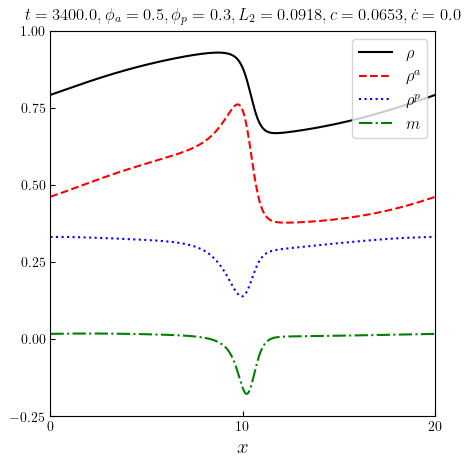

In [162]:
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

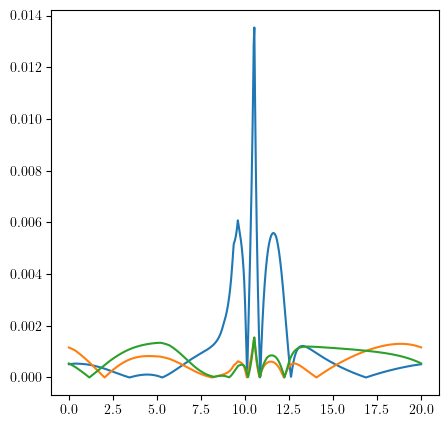

In [168]:
df = circ_diff(f,param);
ddf = circ_diff(df,param);
norm1, norm2, norm3 = full_eq_test(f, param)
@unpack Δx, Lx = param
xs = Δx:Δx:Lx
@unpack DT, v0, DR, Nx, Δx = param
rho = sum(f; dims = 2)
m = f[:,2] - f[:,1]
ds = self_diff.(rho)

fig, ax = subplots(1,1,figsize=(5,5))
ax.plot(xs, norm1./scaler)
ax.plot(xs, norm2./scaler)
ax.plot(xs, norm3./scaler)
# ax.plot(xs, norm1)
# ax.plot(xs, norm2)
# ax.plot(xs, norm3)
# ax.plot(xs, rho)
# ax.plot(xs, ds)
# ax.plot(xs, m)
# ax.plot(xs, ddf[:,1]; linestyle = "--")
# ax.plot(xs, abs.(sum(ddf; dims = 2)))

display(fig)

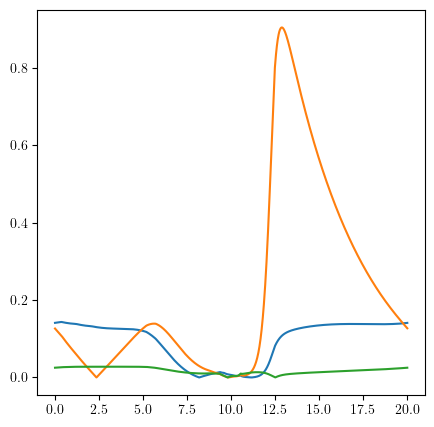

In [164]:
df = circ_diff(f,param);
ddf = circ_diff(df,param);
norm1, norm2, norm3 = inner_test(f, param)
@unpack Δx, Lx = param
xs = Δx:Δx:Lx
@unpack DT, v0, DR, Nx, Δx = param
rho = sum(f; dims = 2)
m = f[:,2] - f[:,1]
ds = self_diff.(rho)

scaler = sum(abs.(df);dims = 2) + sum(abs.(ddf);dims = 2) 

fig, ax = subplots(1,1,figsize=(5,5))
ax.plot(xs, norm1./scaler)
ax.plot(xs, norm2./scaler)
ax.plot(xs, norm3./scaler)
# ax.plot(xs, rho)
# ax.plot(xs, ds)
# ax.plot(xs, m)
# ax.plot(xs, ddf[:,1]; linestyle = "--")
# ax.plot(xs, abs.(sum(ddf; dims = 2)))

display(fig)


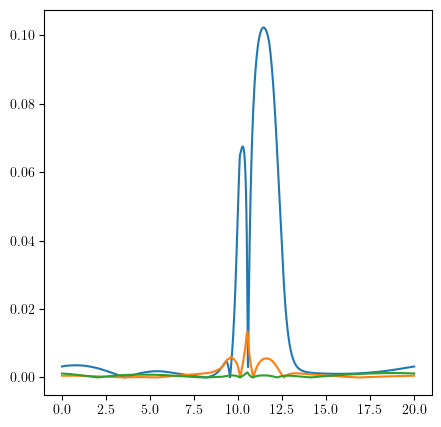

In [167]:
df = circ_diff(f,param);
ddf = circ_diff(df,param);
norm1, norm2, norm3 = outer_test(f, param)
@unpack Δx, Lx = param
xs = Δx:Δx:Lx
@unpack DT, v0, DR, Nx, Δx = param
rho = sum(f; dims = 2)
m = f[:,2] - f[:,1]
ds = self_diff.(rho)

scaler = sum(abs.(df);dims = 2) + sum(abs.(ddf);dims = 2) 

fig, ax = subplots(1,1,figsize=(5,5))
ax.plot(xs, norm1./scaler)
ax.plot(xs, norm2./scaler)
ax.plot(xs, norm3./scaler)
# ax.plot(xs, rho)
# ax.plot(xs, ds)
# ax.plot(xs, m)
# ax.plot(xs, ddf[:,1]; linestyle = "--")
# ax.plot(xs, abs.(sum(ddf; dims = 2)))

display(fig)
